In [1]:
%%capture
!pip install timm
!pip install tensorboard

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch.utils.tensorboard import SummaryWriter
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from PIL import Image

import numpy as np
import timm
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

import tensorflow as tf
import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

import matplotlib.pyplot as plt
plt.rcParams['axes.grid'] = False

import warnings
warnings.filterwarnings("ignore")

if torch.cuda.is_available():
  print(torch.cuda.get_device_name(0))
  print('The number of GPUs available: {}'.format(torch.cuda.device_count()))
device = "cuda" if torch.cuda.is_available() else "cpu" 

Tesla P100-PCIE-16GB
The number of GPUs available: 1


In [3]:
class Augment:
  """
  Parameters:
  global_crops_scale: Range of sizes for the global crops
  local_crops_scale: Range of sizes for the local crops
  n_local_crops: Number of local crops to create
  size: size of the final image

  Attributes:
  global_1, global_2: Two global transforms
  local: Local transform
  """
  def __init__(self, 
               global_crops_scale=(0.4, 1), 
               local_crops_scale=(0.05, 0.4),
               n_local_crops=8, 
               size=224):
    
    self.n_local_crops = n_local_crops
    RandomGaussianBlur = lambda p: transforms.RandomApply(
        [transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 2))],
        p=p,
    )
    
    flip_and_jitter = transforms.Compose(
        [
         transforms.RandomHorizontalFlip(p=0.5),
         transforms.RandomApply(
             [
              transforms.ColorJitter(
                  brightness=0.4,
                  contrast=0.4,
                  saturation=0.2,
                  hue=0.1,
              ),
             ]
         ),
         transforms.RandomGrayscale(p=0.2)
        ]
    )

    normalize = transforms.Compose(
        [
         transforms.ToTensor(),
         transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        ]
    )

    self.global_1 = transforms.Compose(
        [
         transforms.RandomResizedCrop(
             size,
             scale=global_crops_scale,
             interpolation=Image.BICUBIC
         ),
         flip_and_jitter,
         RandomGaussianBlur(1.0),
         normalize,
        ],
    )

    self.global_2 = transforms.Compose(
        [
         transforms.RandomResizedCrop(
             size,
             scale=global_crops_scale,
             interpolation=Image.BICUBIC
         ),
         flip_and_jitter,
         RandomGaussianBlur(0.1),
         transforms.RandomSolarize(170, p=0.2),
         normalize,
        ],
    )
     
    self.local = transforms.Compose(
        [
         transforms.RandomResizedCrop(
             size,
             scale=local_crops_scale,
             interpolation=Image.BICUBIC
         ),
         flip_and_jitter,
         RandomGaussianBlur(0.5),
         normalize,
        ],
    )
     
  def __call__(self, img):
    """
    Parameters
    img: Input image
    Returns
    all_crops: list of torch.Tensor of different img views
    """
    all_crops = list()
    all_crops.append(self.global_1(img))
    all_crops.append(self.global_2(img))

    all_crops.extend([self.local(img) for _ in range(self.n_local_crops)])

    return all_crops

In [4]:
class Head(nn.Module):
  """
  Parameters:
  in_dim: dim of token embedding
  out_dim: dim of final layer that computes softmax
  hidden_dim: dim of hidden layers
  bottleneck_dim: dim of second last layer
  n_layers: number of layers
  norm_last_layer: If True, freeze norm of the weight of last linear layer to 1
  
  Attributes:
  mlp: Vanilla multi-layer perceptron
  last_layer: Reparameterized linear layer with weight normalization 
              'weight' => 'weight_g', 'weight_v' as learnable param
  """

  def __init__(
      self,
      in_dim,
      out_dim,
      hidden_dim=512,
      bottleneck_dim=256,
      n_layers=3,
      norm_last_layer=False,
  ):
    super().__init__()
    if n_layers==1:
      self.mlp = nn.Linear(in_dim, bottleneck_dim)
    else:
      layers = [nn.Linear(in_dim, hidden_dim)]
      layers.append(nn.GELU())
      for _ in range(2, n_layers):
        layers.append(nn.Linear(hidden_dim, hidden_dim))
        layers.append(nn.GELU())
      layers.append(nn.Linear(hidden_dim, bottleneck_dim))
      self.mlp = nn.Sequential(*layers)
    
    self.apply(self._init_weights)

    self.last_layer = nn.utils.weight_norm(
        nn.Linear(bottleneck_dim, out_dim, bias=False)
    )
    self.last_layer.weight_g.data.fill_(1)
    if norm_last_layer:
      self.last_layer.weight_g.requires_grad = False
  
  def _init_weights(self, m):
    if isinstance(m, nn.Linear):
      nn.init.normal_(m.weight, std=0.02)
      if m.bias is not None:
        nn.init.constant_(m.bias, 0)
  
  def forward(self, x):
    """
    Parameters
    x: cls token of shape (n_samples, in_dim)
    Returns
    torch.Tensor shape (n_samples, out_dim)
    """
    
    x = self.mlp(x) #(n_samples, bottleneck_dim)
    x = nn.functional.normalize(x, dim=-1) #(n_samples, bottleneck_dim)
    x = self.last_layer(x) #(n_samples, out_dim)

    return x

In [5]:
class MultiCropWrapper(nn.Module):
  """
  Parameters
  backbone: Instantiated ViT from timm
  new_head: New head on top of backbone
  """

  def __init__(self, backbone, new_head):
    super().__init__()
    backbone.head = nn.Identity() #deactivate original head
    self.backbone = backbone
    self.new_head = new_head
  
  def forward(self, x):
    """
    Parameters
    x: List of torch tensor (n_samples, 3, size, size)
    Returns
    tuple: Tuple of torch tensor (n_sample, out_dim)
    """
    n_crops = len(x)
    concatenated = torch.cat(x, dim=0) #(n_samples*n_crops, 3, size, size)
    cls_embedding = self.backbone(concatenated) #(n_samples*n_crops, in_dim)
    logits = self.new_head(cls_embedding) #(n_samples*n_crops, out_dim)
    chunks = logits.chunk(n_crops) # n_crops*(n_samples, out_dim)

    return chunks

In [6]:
class Loss(nn.Module):
  """
  Parameters
  out_dim: dim of final layer
  teacher_temp, student_temp: softmax temperature
  center_momentum: hyperparameter for ema that determines center logits
  *student-teacher network to prevent mode collapse
  """
  def __init__(
      self, out_dim, teacher_temp=0.04, student_temp=0.1, center_momentum=0.9
  ):
    super().__init__()
    self.student_temp = student_temp
    self.teacher_temp = teacher_temp
    self.center_momentum = center_momentum
    self.register_buffer("center", torch.zeros(1, out_dim))

  def forward(self, student_output, teacher_output):
    """
    Parameters
    student_output, teacher_output: (n_samples, out_dim) represent logits with crops
    Returns
    scalar loss
    """
    student_temp = [s / self.student_temp for s in student_output]
    teacher_temp = [(t - self.center) / self.teacher_temp for t in teacher_output]

    student_sm = [F.log_softmax(s, dim=1) for s in student_temp]
    teacher_sm = [F.softmax(t, dim=-1).detach() for t in teacher_temp] #stop_gradient

    total_loss = 0
    n_loss_terms = 0

    for t_ix, t in enumerate(teacher_sm):
      for s_ix, s in enumerate(student_sm):
        if t_ix == s_ix:
          continue

        loss = torch.sum(-t*s, dim=-1) #(n_samples,)
        total_loss += loss.mean()
        n_loss_terms += 1

        total_loss /= n_loss_terms
        self.update_center(teacher_output)
        
        return total_loss
    
  @torch.no_grad()
  def update_center(self, teacher_output):
    """
    Parameters
    teacher_output: (n_samples, out_dim)
    """
    batch_center = torch.cat(teacher_output).mean(
        dim=0, keepdim=True
    ) #(1, out_dim)
    self.center = self.center * self.center_momentum + batch_center * (
        1 - self.center_momentum
    )

  def clip_gradients(model, clip=2.0):
    """
    Parameters
    model: Module
    clip: Max norm
    """
    for p in model.parameters():
      if p.grad is not None:
        param_norm = p.grad.data.norm()
        clip_coef = clip / (param_norm + 1e-6)
        if clip_coef < 1:
          p.grad.data.mul_(clip_coef)

In [7]:
def compute_knn(backbone, data_loader_train, data_loader_val):
    """
    Returns
    val_accuracy 
    """
    data_loaders = {
        "train": data_loader_train,
        "val": data_loader_val,
    }
    lists = {
        "X_train": [],
        "y_train": [],
        "X_val": [],
        "y_val": [],
    }

    for name, data_loader in data_loaders.items():
        for imgs, y in data_loader:
            imgs = imgs.to(device)
            lists[f"X_{name}"].append(backbone(imgs).detach().cpu().numpy())
            lists[f"y_{name}"].append(y.detach().cpu().numpy())

    arrays = {k: np.concatenate(l) for k, l in lists.items()}

    estimator = KNeighborsClassifier()
    estimator.fit(arrays["X_train"], arrays["y_train"])
    y_val_pred = estimator.predict(arrays["X_val"])

    acc = accuracy_score(arrays["y_val"], y_val_pred)

    return acc

In [8]:
def compute_embedding(backbone, data_loader):
  """
  Parameters
  backbone: ViT, head is identity mapping
  data_loader: validation dataloader without augmentations
  Returns
  embds: Embeddings shape (n_samples, out_dim)
  imgs: Images shape (n_samples, 3, height, width)
  labels: List of strings representing the class
  """
  device = next(backbone.parameters()).device

  embs_l = []
  imgs_l = []
  labels = []

  for img, y in data_loader:
    img = img.to(device)
    embs_l.append(backbone(img).detach().cpu())
    imgs_l.append(((img * 0.224) + 0.45).cpu()) # undo norm
    labels.extend([data_loader.dataset.classes[i] for i in y.tolist()])

  embs = torch.cat(embs_l, dim=0)
  imgs = torch.cat(imgs_l, dim=0)
  
  return embs, imgs, labels

In [9]:
vit_name, dim = "deit_small_patch16_224", 384
label_map = {"n01440764": "tench", "n02102040": "english_springer", "n02979186": "cassette_player", "n03000684": "chain_saw", "n03028079": "church", "n03394916": "french_horn", "n03417042": "garbage_truck", "n03425413": "gas_pump", "n03445777": "golf_ball", "n03888257": "parachute"}
path_dataset_train = "/content/drive/MyDrive/papers/data/imagenette2-320/train"
path_dataset_val = "/content/drive/MyDrive/papers/data/imagenette2-320/val"

In [10]:
transform_aug = Augment(size=224, n_local_crops=4-2)
transform_nor = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        transforms.Resize((224, 224)),
    ]
)

In [11]:
dataset_train_aug = ImageFolder(path_dataset_train, transform=transform_aug)
dataset_train_nor = ImageFolder(path_dataset_train, transform=transform_nor)
dataset_val_nor = ImageFolder(path_dataset_val, transform=transform_nor)

In [12]:
data_loader_train_aug = DataLoader(
        dataset_train_aug,
        batch_size=32,
        shuffle=True,
        drop_last=True,
        num_workers=4,
        pin_memory=True,
      )

data_loader_train_nor = DataLoader(
    dataset_train_nor,
    batch_size=32,
    drop_last=False,
    num_workers=4,
  )

data_loader_val_nor = DataLoader(
    dataset_val_nor,
    batch_size=32,
    drop_last=False,
    num_workers=4,
  )

data_loader_val_nor_subset = DataLoader(
    dataset_val_nor,
    batch_size=32,
    drop_last=False,
    sampler=SubsetRandomSampler(list(range(0, len(dataset_val_nor), 50))),
    num_workers=4,
  )

In [13]:
(img1, img2, img3, img4), label_aug = next(iter(data_loader_train_aug))
img, label_nor = next(iter(data_loader_train_nor))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


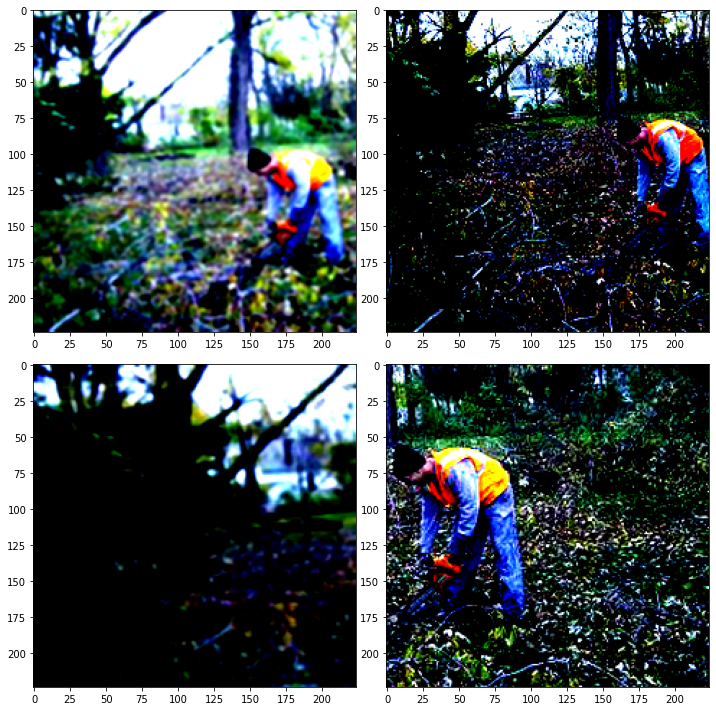

In [14]:
fig, ax = plt.subplots(2, 2, figsize=(10,10))
ax[0, 0].imshow(img1[0].permute(1,2,0).detach().cpu().numpy())
ax[0, 1].imshow(img2[0].permute(1,2,0).detach().cpu().numpy())
ax[1, 0].imshow(img3[0].permute(1,2,0).detach().cpu().numpy())
ax[1, 1].imshow(img4[0].permute(1,2,0).detach().cpu().numpy())
fig.tight_layout()

In [15]:
student_vit = timm.create_model(vit_name, pretrained=True)
teacher_vit = timm.create_model(vit_name, pretrained=True)

student = MultiCropWrapper(student_vit, Head(384, 1024, norm_last_layer=True))
teacher = MultiCropWrapper(teacher_vit, Head(384, 1024))
student, teacher = student.to(device), teacher.to(device)

teacher.load_state_dict(student.state_dict())

for p in teacher.parameters():
    p.requires_grad = False

In [16]:
loss = Loss(1024, teacher_temp=0.04, student_temp=0.1).to(device)
optimizer = torch.optim.AdamW(student.parameters(), lr=0.000125, weight_decay=0.4)

In [17]:
best_acc = 0
n_iters = len(dataset_train_aug) // 32

In [18]:
def train(data_loader_train_aug, data_loader_train_nor,  data_loader_val_nor, data_loader_val_nor_subset,
          student, teacher, criterion, optimizer, writer, device):
  tq = tqdm(enumerate(data_loader_train_aug), total=n_iters)
  for n_steps, (images, _) in tq:
    if n_steps % 200 == 0:
        student.eval()

        # Embedding
        embs, imgs, labels_ = compute_embedding(
            student.backbone,
            data_loader_val_nor_subset,
        )
        writer.add_embedding(
            embs,
            metadata=[label_map[l] for l in labels_],
            label_img=imgs,
            global_step=n_steps,
            tag="embeddings",
        )

        # # KNN
        # current_acc = compute_knn(
        #     student.backbone,
        #     data_loader_train_nor,
        #     data_loader_val_nor
        # )
        # writer.add_scalar("knn-accuracy", current_acc, n_steps)
        # if current_acc > best_acc:
        #     torch.save(student, 'results' / "best_model.pth")
        #     best_acc = current_acc

        student.train()

    images = [img.to(device) for img in images]

    teacher_output = teacher(images[:2])
    student_output = student(images)

    loss = criterion(student_output, teacher_output)

    optimizer.zero_grad()
    loss.backward()
    # clip_gradients(student, 2.0)
    optimizer.step()

    with torch.no_grad():
        for student_ps, teacher_ps in zip(
            student.parameters(), teacher.parameters()
        ):
            teacher_ps.data.mul_(0.9995)
            teacher_ps.data.add_(
                (1 - 0.9995) * student_ps.detach().data
            )

    writer.add_scalar("train_loss", loss, n_steps)

In [19]:
writer = SummaryWriter("result")
tq = tqdm(range(100), total=100)
best_acc = 0
n_steps = 0

for epoch in tq:
  train(data_loader_train_aug, data_loader_train_nor,  data_loader_val_nor, data_loader_val_nor_subset,
        student, teacher, loss, optimizer, writer, device)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

In [ ]:
!tensorboard --logdir=runs


NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.7.0 at http://localhost:6006/ (Press CTRL+C to quit)


In [ ]:
!tensorboard dev upload --logdir runs \
--name "My latest experiment" \
--description "Simple comparison of several hyperparameters"